# Variational GP (VSGP) with mixed input spaces vs Exact Inference vs Exact Inference with Random Fourier Features

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from gpytorch.mlls.variational_elbo import VariationalELBO
from gpytorch.variational import CholeskyVariationalDistribution
from typing import Tuple
import numpy as np
import torch
from gpytorch.mlls.variational_elbo import VariationalELBO
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy

In [22]:


def generate_dummy_data(num_samples: int = 50):
    """
    Generates dummy data for training the GP model.

    :param num_samples: Number of samples to generate.
    :return: Tuple of input tensor and target tensor.
    """
    continuous_feature = np.random.uniform(0, 1, num_samples).reshape(-1, 1)
    discrete_feature = np.random.randint(0, 3, num_samples).reshape(-1, 1)  # Discrete dimension with values in {0, 1, 2}
    
    inputs = np.hstack([continuous_feature, discrete_feature])
    targets = np.sin(2 * np.pi * continuous_feature).flatten() + 0.1 * discrete_feature.flatten() + 0.1 * np.random.randn(num_samples)
    
    return torch.tensor(inputs, dtype=torch.float64).to(device='cuda'), torch.tensor(targets, dtype=torch.float64).unsqueeze(-1).to(device='cuda')

train_X, train_Y = generate_dummy_data(num_samples=100)
print(train_X[1:5])
print(train_Y[1:5])

tensor([[0.1667, 0.0000],
        [0.1590, 0.0000],
        [0.3887, 2.0000],
        [0.9945, 1.0000]], device='cuda:0', dtype=torch.float64)
tensor([[0.8921],
        [1.0227],
        [0.7046],
        [0.1244]], device='cuda:0', dtype=torch.float64)


In [23]:
from gp.variationalgp import MixedSingleTaskVariationalGP
import gpytorch
from botorch import fit_gpytorch_mll

# Categorical feature index
cat_dims = [1]

print(train_X.shape)
print(train_Y.shape)

# Step 2: Instantiate the Model
model = MixedSingleTaskVariationalGP(
    train_X=train_X,
    train_Y=train_Y,
    cat_dims=cat_dims,
    num_outputs=1,
    learn_inducing_points=True,
    # variational_distribution=CholeskyVariationalDistribution(num_inducing_points=64),
    # variational_strategy=VariationalStrategy,
    inducing_points=1024  # Or provide actual inducing points tensor
).to(device='cuda')

# Step 3: Train the Model
# Define the marginal log likelihood
mll = VariationalELBO(model.likelihood, model.model, train_Y.numel())

# Fit the model
# fit_gpytorch_mll(mll)

torch.Size([100, 2])
torch.Size([100, 1])
check torch.Size([])


/home/matthijs/bsc/BachelorProject/.venv/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/matthijs/bsc/BachelorProject/.venv/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0861], device='cuda:0', dtype=torch.float64), std = tensor([0.7069], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


In [31]:
from tqdm import tqdm

# I do not believe the standard fit_gpytorch_mll function works
num_epochs = 32

model.train()
model.likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for i in range(num_epochs):
    # naive - no batching just epoch over all data
    optimizer.zero_grad()
    output = model(train_X)
    loss = -mll(output, train_Y).mean()
    print("loss -", loss)
    loss.backward()
    optimizer.step()

torch.Size([100, 2])
loss - tensor(-1.0780, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)
torch.Size([100, 2])
loss - tensor(-1.8211, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)
torch.Size([100, 2])


/home/matthijs/bsc/BachelorProject/.venv/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/matthijs/bsc/BachelorProject/.venv/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
/home/matthijs/bsc/BachelorProject/.venv/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/matthijs/bsc/BachelorProject/.venv/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/matthijs/bsc/BachelorProject/.venv/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/matthijs/bsc/Bachel

NotPSDError: Matrix not positive definite after repeatedly adding jitter up to 1.0e-03.

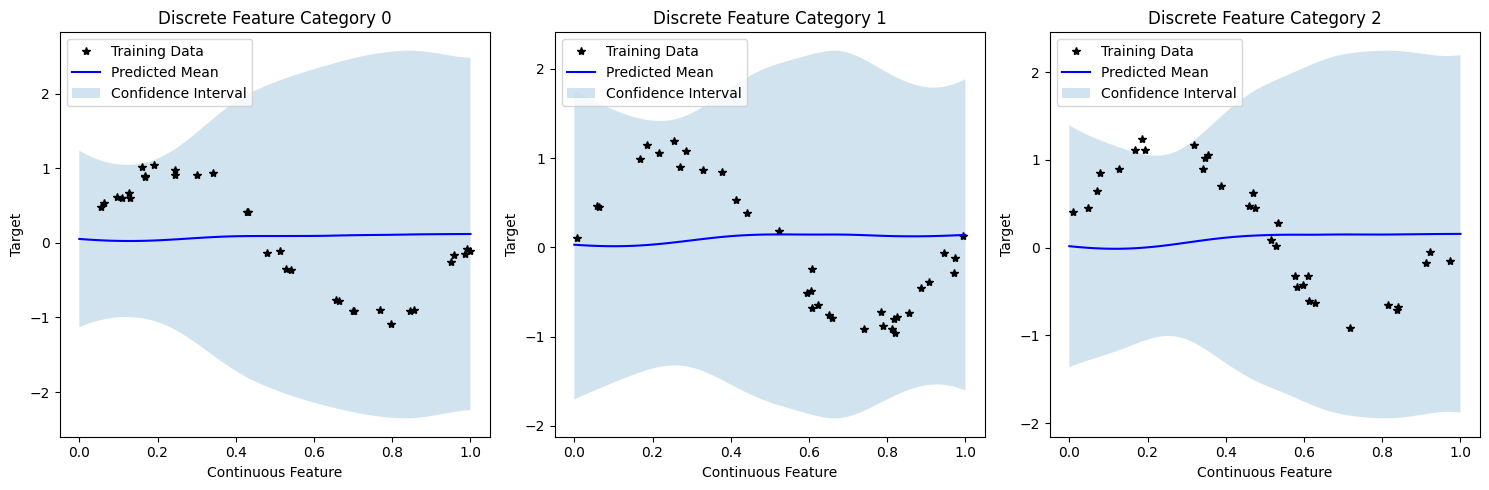

In [25]:
# Step 4: Make Predictions
# Generate test data
"""
test_continuous_feature = np.linspace(0, 1, 100).reshape(-1, 1)
test_categorical_feature = np.zeros_like(test_continuous_feature)  # Use category 0 for visualization
test_X = torch.tensor(np.hstack([test_continuous_feature, test_categorical_feature]), dtype=torch.float64)

# Get the model in evaluation mode
model.eval()
model.likelihood.eval()

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = model.likelihood(model(test_X))
    mean = predictions.mean.numpy()
    lower, upper = predictions.confidence_region()
    lower = lower.numpy()
    upper = upper.numpy()
"""

# Step 4: Make Predictions for Each Discrete Category
num_categories = 3
plt.figure(figsize=(15, 5))
for i in range(num_categories):
    # Generate test data for the current category
    test_continuous_feature = np.linspace(0, 1, 100).reshape(-1, 1)
    test_categorical_feature = np.full_like(test_continuous_feature, fill_value=i)  # Use current category
    test_X = torch.tensor(np.hstack([test_continuous_feature, test_categorical_feature]), dtype=torch.float64, device='cuda')

    # Get the model in evaluation mode
    model.eval()
    model.likelihood.eval()

    # Make predictions
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        predictions = model.likelihood(model(test_X))
        mean = predictions.mean.cpu().numpy()
        lower, upper = predictions.confidence_region()
        lower = lower.cpu().numpy()
        upper = upper.cpu().numpy()

    # Plot the results
    plt.subplot(1, num_categories, i+1)
    plt.plot(train_X[train_X[:, 1] == i][:, 0].cpu().numpy(), train_Y[train_X[:, 1] == i].cpu().numpy(), 'k*', label='Training Data')
    plt.plot(test_continuous_feature, mean, 'b', label='Predicted Mean')
    plt.fill_between(test_continuous_feature.flatten(), lower, upper, alpha=0.2, label='Confidence Interval')
    plt.xlabel('Continuous Feature')
    plt.ylabel('Target')
    plt.title(f'Discrete Feature Category {i}')
    plt.legend()

plt.tight_layout()
plt.show()

## Replication with SingleMixedTaskGP

In [26]:
from gpytorch import ExactMarginalLogLikelihood
from botorch.models import MixedSingleTaskGP

# Categorical feature index
cat_dims = [1]

# Step 2: Instantiate the Model
model = MixedSingleTaskGP(train_X=train_X, train_Y=train_Y, cat_dims=cat_dims).to(device='cuda')

mll = ExactMarginalLogLikelihood(model.likelihood, model)

fit_gpytorch_mll(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-06)
    )
  )
  (model): MixedSingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-06)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): AdditiveKernel(
      (kernels): ModuleList(
        (0): ScaleKernel(
          (base_kernel): AdditiveKernel(
            (kernels): ModuleList(
              (0): MaternKernel(
                (raw_lengthscale_constraint): GreaterThan(1.000E-04)
              )
              (1): ScaleKernel(
                (base_kernel): CategoricalKernel(
                  (raw_lengthscale_constraint): GreaterThan(1.000E-06)
                )
                (raw_outputscale_constraint): Positive()
              )
            )
         

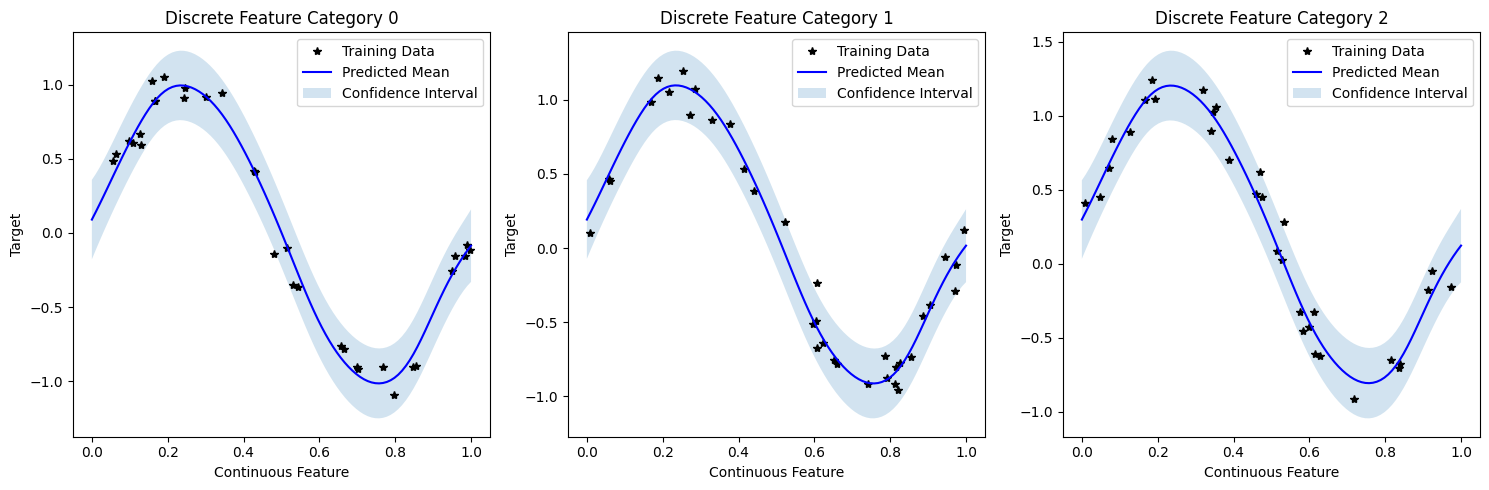

In [27]:
# Step 4: Make Predictions for Each Discrete Category
num_categories = 3
plt.figure(figsize=(15, 5))
for i in range(num_categories):
    # Generate test data for the current category
    test_continuous_feature = np.linspace(0, 1, 100).reshape(-1, 1)
    test_categorical_feature = np.full_like(test_continuous_feature, fill_value=i)  # Use current category
    test_X = torch.tensor(np.hstack([test_continuous_feature, test_categorical_feature]), dtype=torch.float32).to(device='cuda')

    # Get the model in evaluation mode
    model.eval()
    model.likelihood.eval()

    # Make predictions
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        predictions = model.likelihood(model(test_X))
        mean = predictions.mean.cpu().numpy()
        lower, upper = predictions.confidence_region()
        lower = lower.cpu().numpy()
        upper = upper.cpu().numpy()

    # Plot the results
    plt.subplot(1, num_categories, i+1)
    plt.plot(train_X[train_X[:, 1] == i][:, 0].cpu().numpy(), train_Y[train_X[:, 1] == i].cpu().numpy(), 'k*', label='Training Data')
    plt.plot(test_continuous_feature, mean, 'b', label='Predicted Mean')
    plt.fill_between(test_continuous_feature.flatten(), lower, upper, alpha=0.2, label='Confidence Interval')
    plt.xlabel('Continuous Feature')
    plt.ylabel('Target')
    plt.title(f'Discrete Feature Category {i}')
    plt.legend()

plt.tight_layout()
plt.show()

## Same but with RFF kernel

In [28]:
from typing import List
from gpytorch.kernels import RFFKernel


class RFFKernelAdapter:
    """
    Problem with MixedSigleTaskGP is that it strictly allows kernels to only specify
    the batch_shape, ard_num_dims and lengthscale contraint.
    """
    num_samples = 1024

    @staticmethod
    def create_kernel(batch_shape: torch.Size, ard_num_dims: int, active_dims: List[int]) -> RFFKernel:
        return RFFKernel(
            num_samples=RFFKernelAdapter.num_samples,
            batch_shape=batch_shape,
            ard_num_dims=ard_num_dims,
            active_dims=active_dims
        )

In [29]:
# Categorical feature index
cat_dims = [1]

# Step 2: Instantiate the Model
model = MixedSingleTaskGP(train_X=train_X, train_Y=train_Y, cat_dims=cat_dims,
                          cont_kernel_factory=RFFKernelAdapter.create_kernel).to(device='cuda')

mll = ExactMarginalLogLikelihood(model.likelihood, model)

fit_gpytorch_mll(mll)

/home/matthijs/bsc/BachelorProject/.venv/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0861], device='cuda:0', dtype=torch.float64), std = tensor([0.7069], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-06)
    )
  )
  (model): MixedSingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-06)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): AdditiveKernel(
      (kernels): ModuleList(
        (0): ScaleKernel(
          (base_kernel): AdditiveKernel(
            (kernels): ModuleList(
              (0): RFFKernel(
                (raw_lengthscale_constraint): Positive()
              )
              (1): ScaleKernel(
                (base_kernel): CategoricalKernel(
                  (raw_lengthscale_constraint): GreaterThan(1.000E-06)
                )
                (raw_outputscale_constraint): Positive()
              )
            )
          )
          (r

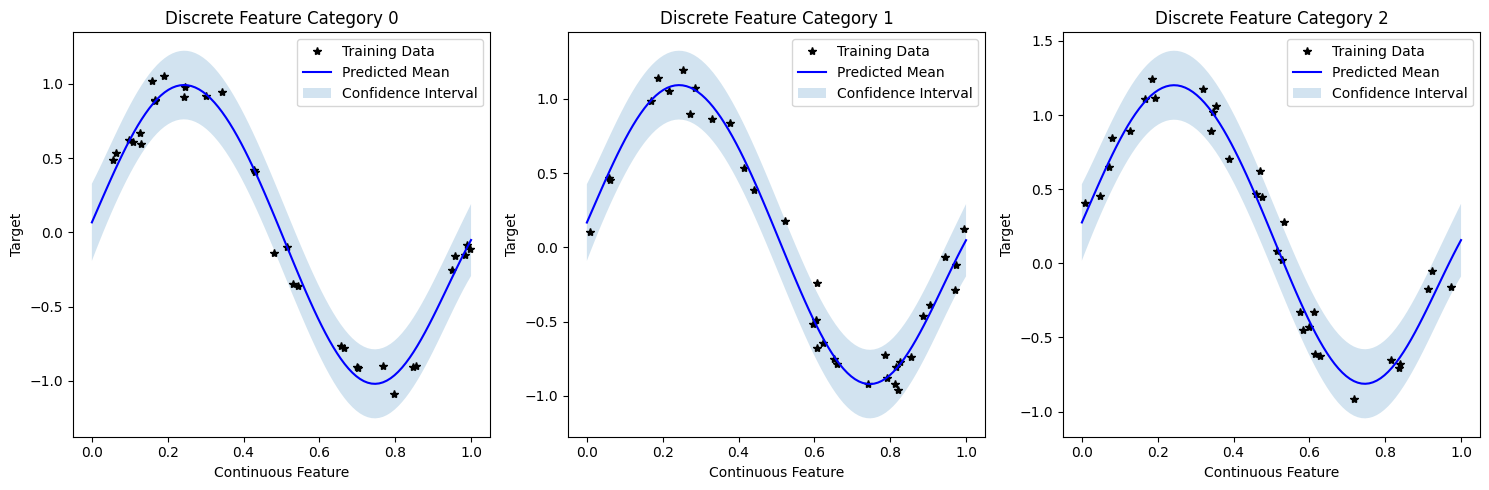

In [30]:
# Step 4: Make Predictions for Each Discrete Category
num_categories = 3
plt.figure(figsize=(15, 5))
for i in range(num_categories):
    # Generate test data for the current category
    test_continuous_feature = np.linspace(0, 1, 100).reshape(-1, 1)
    test_categorical_feature = np.full_like(test_continuous_feature, fill_value=i)  # Use current category
    test_X = torch.tensor(np.hstack([test_continuous_feature, test_categorical_feature]), dtype=torch.float32).to(device='cuda')

    # Get the model in evaluation mode
    model.eval()
    model.likelihood.eval()

    # Make predictions
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        predictions = model.likelihood(model(test_X))
        mean = predictions.mean.cpu().numpy()
        lower, upper = predictions.confidence_region()
        lower = lower.cpu().numpy()
        upper = upper.cpu().numpy()

    # Plot the results
    plt.subplot(1, num_categories, i+1)
    plt.plot(train_X[train_X[:, 1] == i][:, 0].cpu().numpy(), train_Y[train_X[:, 1] == i].cpu().numpy(), 'k*', label='Training Data')
    plt.plot(test_continuous_feature, mean, 'b', label='Predicted Mean')
    plt.fill_between(test_continuous_feature.flatten(), lower, upper, alpha=0.2, label='Confidence Interval')
    plt.xlabel('Continuous Feature')
    plt.ylabel('Target')
    plt.title(f'Discrete Feature Category {i}')
    plt.legend()

plt.tight_layout()
plt.show()